https://qiskit.org/ecosystem/machine-learning/tutorials/11_quantum_convolutional_neural_networks.html#5.-Training-our-QCNN

In [1]:
#Usar Sklearn para minmax
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler

# Pandas y numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from datetime import datetime

# Qiskit
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import library 
from qiskit import Aer, execute
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator, Pauli

#ML Qiskit
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

# Otros
import math
import random
from IPython.display import clear_output


# Minimizar
from scipy.optimize import minimize

np.random.seed(1)

In [2]:
df=pd.read_csv('./datos/AirPassengers.csv')
df['Month']=pd.to_datetime(df['Month'], infer_datetime_format=True)
df=df.set_index(['Month'])
df_log=np.log(df)
data_shift=df_log-df_log.shift()
data_shift = data_shift.dropna()

# Crear los conjuntos
ptrain=0.8
pasajeros = np.array(data_shift['#Passengers'])
pasajeros_train = pasajeros[:int(pasajeros.shape[0]*0.8)]
pasajeros_test = pasajeros[int(pasajeros.shape[0]*0.8):]

tiempo = data_shift.drop(['#Passengers'], axis=1)
tiempo_train = tiempo.head(int(pasajeros.shape[0]*0.8))
tiempo_test = tiempo.tail(pasajeros.shape[0] - int(pasajeros.shape[0]*0.8))

# Pasemos a numpy
window = 8;
tam_train = pasajeros_train.shape[0] - window
tam_test = pasajeros_test.shape[0] - window
conjunto_train = []
objetivo_train = []
conjunto_test = []
objetivo_test = []

for i in range(0,tam_train):
    conjunto_train.append(pasajeros_train[0+i:window+i])
    objetivo_train.append(pasajeros_train[window+i])

for i in range(0,tam_test):
    conjunto_test.append(pasajeros_test[0+i:window+i])
    objetivo_test.append(pasajeros_test[window+i])
    
objetivo_train = np.array(objetivo_train)
conjunto_train = np.array(conjunto_train)

conjunto_train = conjunto_train/np.linalg.norm(conjunto_train)
objetivo_train = objetivo_train/np.linalg.norm(objetivo_train)

#No vamos a usar ahora mismo ningún conjunto de validación...

objetivo_test = np.array(objetivo_test)
conjunto_test = np.array(conjunto_test)

In [3]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [4]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

In [5]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

In [15]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "с1"), list(range(8)), inplace=True)

for i in range(7):
    ansatz.cz(i,i+1)

# First Convolutional Layer
ansatz.compose(conv_layer(8, "с11"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

for i in range(4, 7):
    ansatz.cz(i,i+1)

# First Convolutional Layer
ansatz.compose(conv_layer(4, "с22"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

for i in range(6, 7):
    ansatz.cz(i,i+1)

# First Convolutional Layer
ansatz.compose(conv_layer(2, "с33"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)]) # Solo se tiene en cuenta el valor del primer qubit

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)



In [16]:
regressor = NeuralNetworkRegressor(
    neural_network= qnn,
    optimizer=COBYLA(maxiter=500),  # Set max iterations here
    callback=callback_graph,
    loss="squared_error",
)

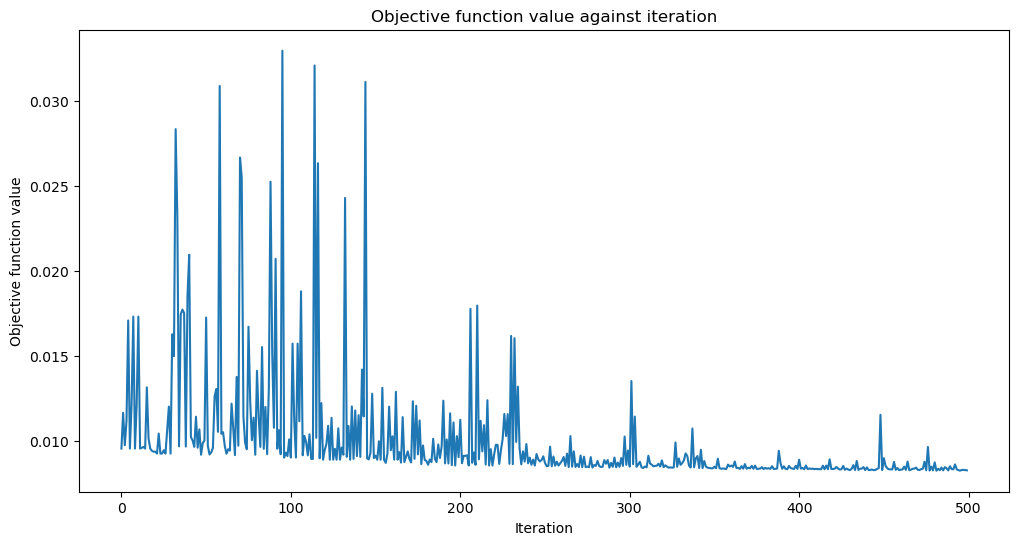

In [17]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(conjunto_train, objetivo_train)

In [18]:
regressor.score(conjunto_train, objetivo_train)

0.11711886306485375

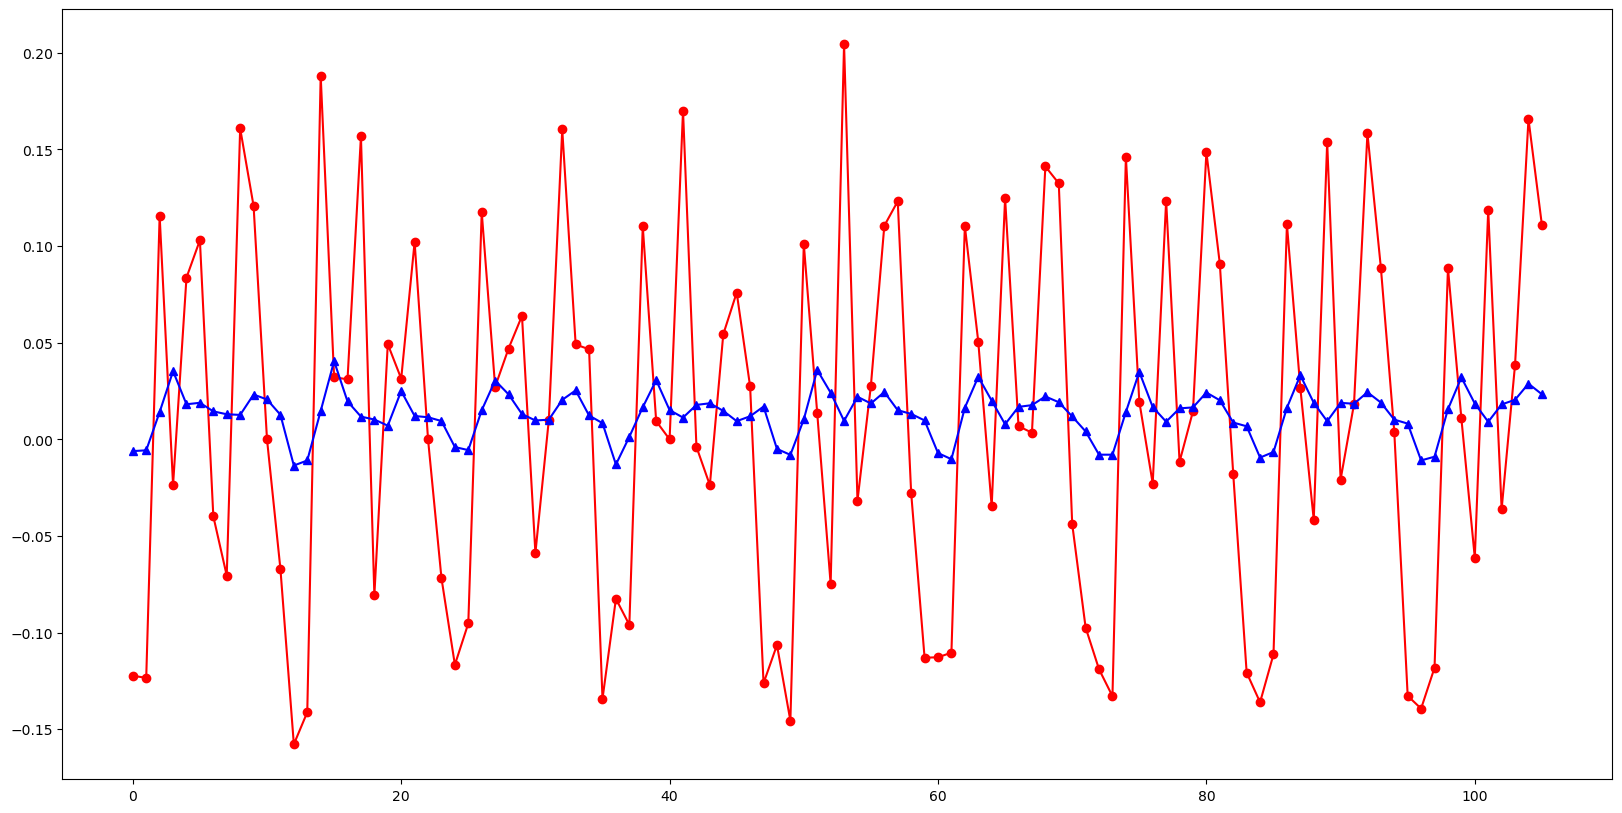

1.0021631951279175

In [19]:
espacio = np.arange(0,objetivo_train.shape[0])
y_ = regressor.predict(conjunto_train)
plt.figure(figsize=(20,10))
plt.plot(espacio ,objetivo_train, marker='o',color='red', label='Verdaderos')
plt.plot(espacio,y_ , color='blue', marker='^',label='Predicciones') 
plt.show()
np.sum( (objetivo_train - y_)**2)/len(objetivo_train)